In [35]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time
from scipy.interpolate import RegularGridInterpolator

In [36]:
# ------------------------------------------------------------
# 1) SOLVER
# ------------------------------------------------------------
def crank_nicolson_2d(x_edges, y_edges, D, u0, dt, T, verbose=False):
    # x_edges, y_edges : edge arrays length Nx+1, Ny+1
    # D, u0 : cell-centered arrays shape (Nx, Ny)
    Nx = len(x_edges) - 1
    Ny = len(y_edges) - 1
    dx = x_edges[1:] - x_edges[:-1]  # length Nx
    dy = y_edges[1:] - y_edges[:-1]  # length Ny

    N = Nx * Ny
    u = u0.reshape(N)

    def idx(i, j):
        return i * Ny + j

    rows = []
    cols = []
    vals = []

    for i in range(Nx):
        for j in range(Ny):
            p = idx(i, j)
            diag = 0.0

            # West face
            if i > 0:
                D_w = 0.5 * (D[i, j] + D[i - 1, j])
                dx_w = 0.5 * (dx[i - 1] + dx[i])
                coef = D_w / (dx_w * dx[i])
                rows.append(p)
                cols.append(idx(i - 1, j))
                vals.append(+coef)
                diag -= coef

            # East face
            if i < Nx - 1:
                D_e = 0.5 * (D[i, j] + D[i + 1, j])
                dx_e = 0.5 * (dx[i] + dx[i + 1])
                coef = D_e / (dx_e * dx[i])
                rows.append(p)
                cols.append(idx(i + 1, j))
                vals.append(+coef)
                diag -= coef

            # South face
            if j > 0:
                D_s = 0.5 * (D[i, j] + D[i, j - 1])
                dy_s = 0.5 * (dy[j - 1] + dy[j])
                coef = D_s / (dy_s * dy[j])
                rows.append(p)
                cols.append(idx(i, j - 1))
                vals.append(+coef)
                diag -= coef

            # North face
            if j < Ny - 1:
                D_n = 0.5 * (D[i, j] + D[i, j + 1])
                dy_n = 0.5 * (dy[j] + dy[j + 1])
                coef = D_n / (dy_n * dy[j])
                rows.append(p)
                cols.append(idx(i, j + 1))
                vals.append(+coef)
                diag -= coef

            rows.append(p)
            cols.append(p)
            vals.append(diag)

    A = sp.csr_matrix((vals, (rows, cols)), shape=(N, N))

    # Diagnostics
    if verbose:
        sym_diff = (A - A.T).nnz
        row_sums = np.array(A.sum(axis=1)).ravel()
        print("A - A.T nonzeros:", sym_diff)
        print("row_sums min/max:", row_sums.min(), row_sums.max())
        print("diag min/max:", A.diagonal().min(), A.diagonal().max())

    M_L = sp.eye(N) - 0.5 * dt * A
    M_R = sp.eye(N) + 0.5 * dt * A

    steps = int(round(T / dt))
    for _ in range(steps):
        rhs = M_R @ u
        u = spla.spsolve(M_L, rhs)

    return u.reshape((Nx, Ny)), A


# ------------------------------------------------------------
# 2) MESH GENERATION & REFINEMENT
# ------------------------------------------------------------
def make_uniform_mesh_2d(Nx, Ny):
    x = np.linspace(0, 1, Nx + 1)
    y = np.linspace(0, 1, Ny + 1)
    xc = 0.5 * (x[:-1] + x[1:])
    yc = 0.5 * (y[:-1] + y[1:])
    return x, y, xc, yc


def refine_uniform_mesh_2d(x, y):
    Nx = len(x) - 1
    Ny = len(y) - 1

    # Build refined edges by inserting midpoint directly
    x_new = np.empty(2 * Nx + 1)
    y_new = np.empty(2 * Ny + 1)

    # Fill edges
    x_new[0::2] = x  # 0, 2, 4, ...
    x_new[1::2] = 0.5 * (x[:-1] + x[1:])  # midpoints

    y_new[0::2] = y
    y_new[1::2] = 0.5 * (y[:-1] + y[1:])

    # Compute centers
    xc_new = 0.5 * (x_new[:-1] + x_new[1:])
    yc_new = 0.5 * (y_new[:-1] + y_new[1:])

    return x_new, y_new, xc_new, yc_new


def refine_adaptive_mesh(x_edges, y_edges, u_field, threshold_ratio=0.2):
    """
    Refines mesh where gradient magnitude of u_field is high.
    Maintains rectangular tensor-product structure.
    """
    xc = 0.5 * (x_edges[:-1] + x_edges[1:])
    yc = 0.5 * (y_edges[:-1] + y_edges[1:])

    # 1. Compute Gradients
    # np.gradient handles non-uniform spacing if we pass xc, yc
    grads = np.gradient(u_field, xc, yc)
    grad_mag = np.sqrt(grads[0] ** 2 + grads[1] ** 2)

    # 2. Determine Threshold
    # We refine any cell where gradient is > X% of the max gradient
    threshold = threshold_ratio * np.max(grad_mag)
    mask = grad_mag > threshold

    # 3. Project Mask to Axes
    # Since the solver loops (for i in Nx), we must refine the WHOLE column i
    # if ANY cell in that column has a sharp gradient.
    # axis 1 is y-axis (columns), axis 0 is x-axis (rows)
    refine_x_indices = np.any(mask, axis=1)
    refine_y_indices = np.any(mask, axis=0)

    # 4. Helper to insert midpoints
    def split_edges(edges, should_split):
        new_edges = []
        for i, split in enumerate(should_split):
            new_edges.append(edges[i])
            if split:
                new_edges.append(0.5 * (edges[i] + edges[i + 1]))
        new_edges.append(edges[-1])
        return np.array(new_edges)

    x_new = split_edges(x_edges, refine_x_indices)
    y_new = split_edges(y_edges, refine_y_indices)

    xc_new = 0.5 * (x_new[:-1] + x_new[1:])
    yc_new = 0.5 * (y_new[:-1] + y_new[1:])

    return x_new, y_new, xc_new, yc_new


# ------------------------------------------------------------
# 3) AMBIPOLAR DIFFUSION COEFFICIENT AND INITIAL CONDITION
# ------------------------------------------------------------
def ambipolar_D_2d(xc, yc, mu_i=10.0, mu_e=500.0, spacial_variation=True):
    """
    mu [m^2/V/s]: mobility
    Di, De [m^2/s]: diffusion coefficients
    """
    Xc, Yc = np.meshgrid(xc, yc, indexing="ij")

    Di = 0.02

    if spacial_variation:
        Te = 1 + 0.01 * np.sin(2 * np.pi * Xc) + 0.01 * np.cos(2 * np.pi * Yc)
        Ti = 0.1 * np.ones_like(Xc)
    else:
        Te = 1.0 * np.ones_like(Xc)
        Ti = 0.1 * np.ones_like(Xc)

    return Di * (Te / Ti + 1)


def initial_condition(xc, yc):
    Xc, Yc = np.meshgrid(xc, yc, indexing="ij")
    # Using a slightly sharper Gaussian to test the refinement
    return np.exp(-((Xc - 0.5) ** 2 + (Yc - 0.5) ** 2) / 0.005)

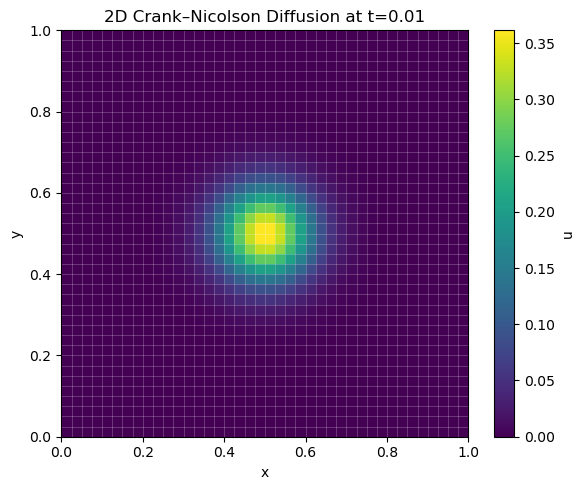

In [37]:
# ------------------------------------------------------------
# 4) RUN AND PLOT A SIMPLE 2D TEST
# ------------------------------------------------------------
Nx = 40
Ny = 40
dt = 1e-4
T = 0.01

x, y, xc, yc = make_uniform_mesh_2d(Nx, Ny)

D = ambipolar_D_2d(xc, yc)

u0 = initial_condition(xc, yc)

u, A = crank_nicolson_2d(x, y, D, u0, dt, T)

plt.figure(figsize=(6, 5))
plt.pcolormesh(x, y, u.T, shading="auto")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"2D Crank–Nicolson Diffusion at t={T}")

plt.vlines(x, 0, 1, color="w", alpha=0.3, lw=0.5)
plt.hlines(y, 0, 1, color="w", alpha=0.3, lw=0.5)

plt.colorbar(label="u")
plt.tight_layout()
plt.show()

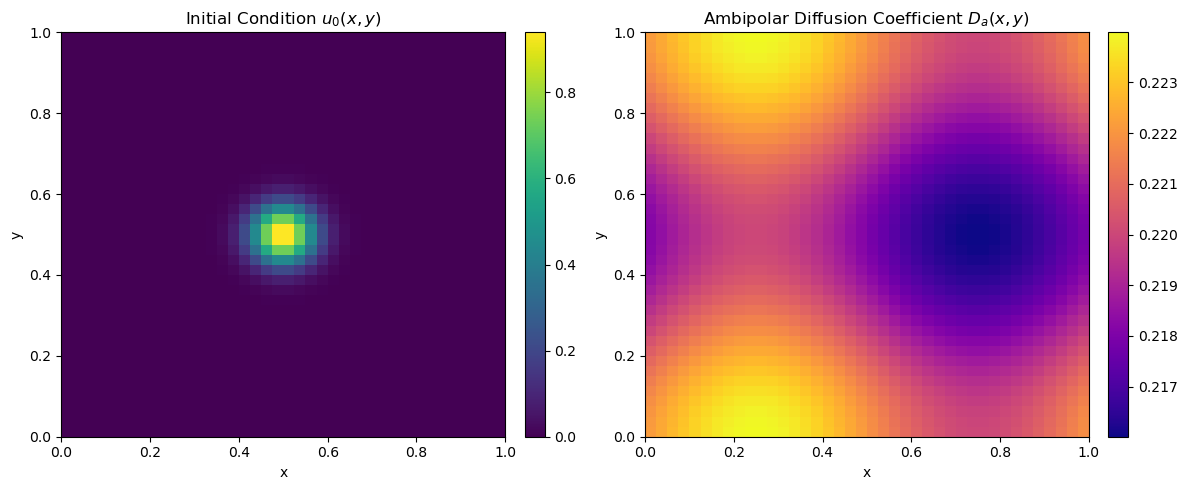

In [38]:
D_final = ambipolar_D_2d(xc, yc)
u0_final = initial_condition(xc, yc)

# Create Meshgrid for plotting
X3, Y3 = np.meshgrid(xc, yc, indexing="ij")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# --- Plot 1: Initial Condition (u0) ---
pcm1 = ax[0].pcolormesh(X3, Y3, u0_final, shading="nearest", cmap="viridis")
ax[0].set_title(r"Initial Condition $u_0(x,y)$")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
fig.colorbar(pcm1, ax=ax[0], fraction=0.046, pad=0.04)


# --- Plot 2: Ambipolar Diffusion Coefficient (D_a) ---
pcm2 = ax[1].pcolormesh(X3, Y3, D_final, shading="nearest", cmap="plasma")
ax[1].set_title(r"Ambipolar Diffusion Coefficient $D_a(x,y)$")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
fig.colorbar(pcm2, ax=ax[1], fraction=0.046, pad=0.04)


plt.tight_layout()
plt.show()

In [ ]:
# ------------------------------------------------------------
# 5) UNIFORM MESH REFINEMENT
# ------------------------------------------------------------
x, y, xc, yc = make_uniform_mesh_2d(40, 40)
x2, y2, xc2, yc2 = refine_uniform_mesh_2d(x, y)

D = ambipolar_D_2d(xc2, yc2)

Xc2, Yc2 = np.meshgrid(xc2, yc2, indexing="ij")
u0 = np.exp(-((Xc2 - 0.5) ** 2 + (Yc2 - 0.5) ** 2) / 0.01)
print(f"2. Running Uniform L1 ({len(xc2)}x{len(yc2)})...")
u_1, A = crank_nicolson_2d(x2, y2, D, u0, dt, T)


x3, y3, xc3, yc3 = refine_uniform_mesh_2d(x2, y2)
D = ambipolar_D_2d(xc3, yc3)

Xc3, Yc3 = np.meshgrid(xc3, yc3, indexing="ij")
u0 = np.exp(-((Xc3 - 0.5) ** 2 + (Yc3 - 0.5) ** 2) / 0.01)
print(f"2. Running Uniform L2 ({len(xc3)}x{len(yc3)})...")
u_2, A = crank_nicolson_2d(x3, y3, D, u0, dt, T)

print("Done")

2. Running Uniform L1 (80x80)...
2. Running Uniform L2 (160x160)...


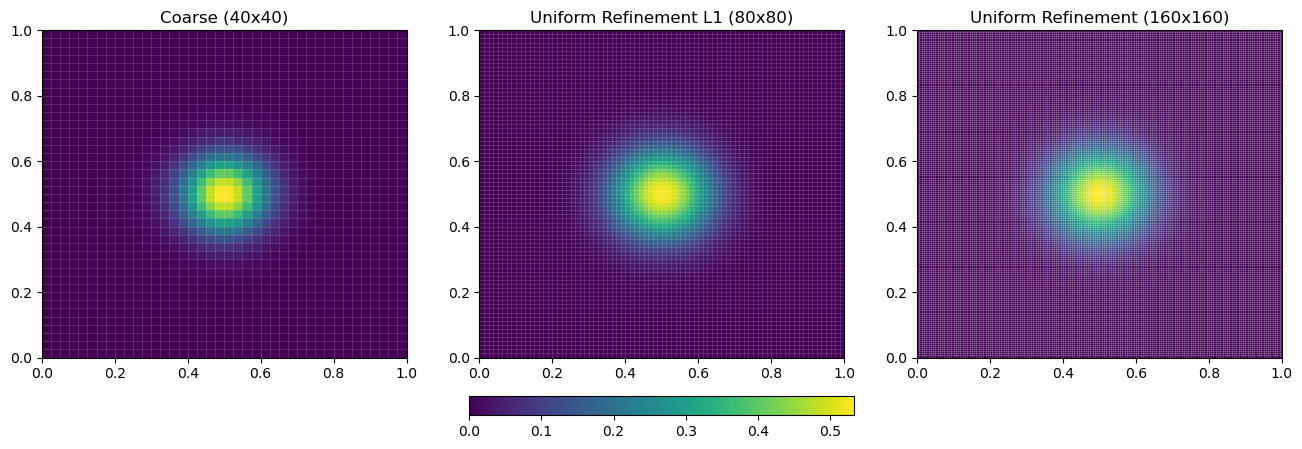

In [40]:
# ------------------------------------------------------------
# 6) UNIFORM REFINEMENT VISUALIZATION
# ------------------------------------------------------------
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

# 1. Plot Coarse
X, Y = np.meshgrid(x, y, indexing="ij")
ax[0].pcolormesh(X, Y, u, shading="flat", cmap="viridis")
ax[0].vlines(x, 0, 1, color="w", alpha=0.2, lw=0.5)
ax[0].hlines(y, 0, 1, color="w", alpha=0.2, lw=0.5)
ax[0].set_title(f"Coarse ({len(xc)}x{len(yc)})")

# 2. Plot Level 1
X2, Y2 = np.meshgrid(x2, y2, indexing="ij")
ax[1].pcolormesh(X2, Y2, u_1, shading="flat", cmap="viridis")
ax[1].vlines(x2, 0, 1, color="w", alpha=0.2, lw=0.5)
ax[1].hlines(y2, 0, 1, color="w", alpha=0.2, lw=0.5)
ax[1].set_title(f"Uniform Refinement L1 ({len(xc2)}x{len(yc2)})")

# 3. Plot Level 2
X3, Y3 = np.meshgrid(x3, y3, indexing="ij")
pcm = ax[2].pcolormesh(X3, Y3, u_2, shading="flat", cmap="viridis")
ax[2].vlines(x3, 0, 1, color="w", alpha=0.3, lw=0.5)
ax[2].hlines(y3, 0, 1, color="w", alpha=0.3, lw=0.5)
ax[2].set_title(f"Uniform Refinement ({len(xc3)}x{len(yc3)})")

plt.colorbar(pcm, ax=ax, orientation="horizontal", fraction=0.05, pad=0.1)
plt.show()

In [ ]:
# ------------------------------------------------------------
# 7) ADAPTIVE MESH REFINEMENT
# ------------------------------------------------------------
dt = 1e-4
T = 0.01  # Short time to keep gradients sharp

# --- A) Coarse Pass ---
Nx, Ny = 40, 40  # Starting very coarse to make the effect obvious
x, y, xc, yc = make_uniform_mesh_2d(Nx, Ny)
D = ambipolar_D_2d(xc, yc)
u0 = initial_condition(xc, yc)

print(f"1. Running Coarse ({len(xc)}x{len(yc)})...")
u_coarse, _ = crank_nicolson_2d(x, y, D, u0, dt, T)

# --- B) Adaptive Refinement (Level 1) ---
# Use the Coarse result to find gradients
x2, y2, xc2, yc2 = refine_adaptive_mesh(x, y, u_coarse, threshold_ratio=0.2)

# --- C) Fine Pass (Level 1) ---
D2 = ambipolar_D_2d(xc2, yc2)
u0_2 = initial_condition(xc2, yc2)

print(f"2. Running Adaptive L1 ({len(xc2)}x{len(yc2)})...")
u_fine, _ = crank_nicolson_2d(x2, y2, D2, u0_2, dt, T)

# --- D) Adaptive Refinement (Level 2) ---
# Use the Level 1 result (u_fine) to find even sharper gradients
x3, y3, xc3, yc3 = refine_adaptive_mesh(x2, y2, u_fine, threshold_ratio=0.2)

# --- E) Fine Pass (Level 2) ---
D3 = ambipolar_D_2d(xc3, yc3)
u0_3 = initial_condition(xc3, yc3)

print(f"3. Running Adaptive L2 ({len(xc3)}x{len(yc3)})...")
u_fine_L2, _ = crank_nicolson_2d(x3, y3, D3, u0_3, dt, T)
print("Done")

1. Running Coarse (40x40)...
2. Running Adaptive L1 (56x56)...
3. Running Adaptive L2 (88x88)...


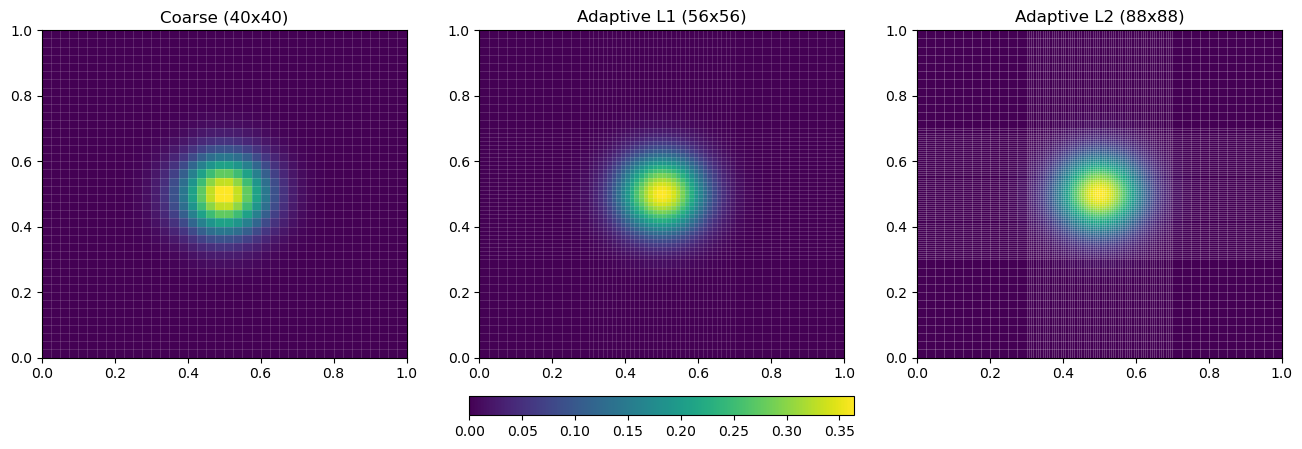

In [42]:
# ------------------------------------------------------------
# 8) ADAPTIVE REFINEMENT VISUALIZATION
# ------------------------------------------------------------
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

# 1. Plot Coarse
X, Y = np.meshgrid(x, y, indexing="ij")
ax[0].pcolormesh(X, Y, u_coarse, shading="flat", cmap="viridis")
ax[0].vlines(x, 0, 1, color="w", alpha=0.2, lw=0.5)
ax[0].hlines(y, 0, 1, color="w", alpha=0.2, lw=0.5)
ax[0].set_title(f"Coarse ({len(xc)}x{len(yc)})")

# 2. Plot Level 1
X2, Y2 = np.meshgrid(x2, y2, indexing="ij")
ax[1].pcolormesh(X2, Y2, u_fine, shading="flat", cmap="viridis")
ax[1].vlines(x2, 0, 1, color="w", alpha=0.2, lw=0.5)
ax[1].hlines(y2, 0, 1, color="w", alpha=0.2, lw=0.5)
ax[1].set_title(f"Adaptive L1 ({len(xc2)}x{len(yc2)})")

# 3. Plot Level 2
X3, Y3 = np.meshgrid(x3, y3, indexing="ij")
pcm = ax[2].pcolormesh(X3, Y3, u_fine_L2, shading="flat", cmap="viridis")
ax[2].vlines(x3, 0, 1, color="w", alpha=0.3, lw=0.5)
ax[2].hlines(y3, 0, 1, color="w", alpha=0.3, lw=0.5)
ax[2].set_title(f"Adaptive L2 ({len(xc3)}x{len(yc3)})")

plt.colorbar(pcm, ax=ax, orientation="horizontal", fraction=0.05, pad=0.1)
plt.show()

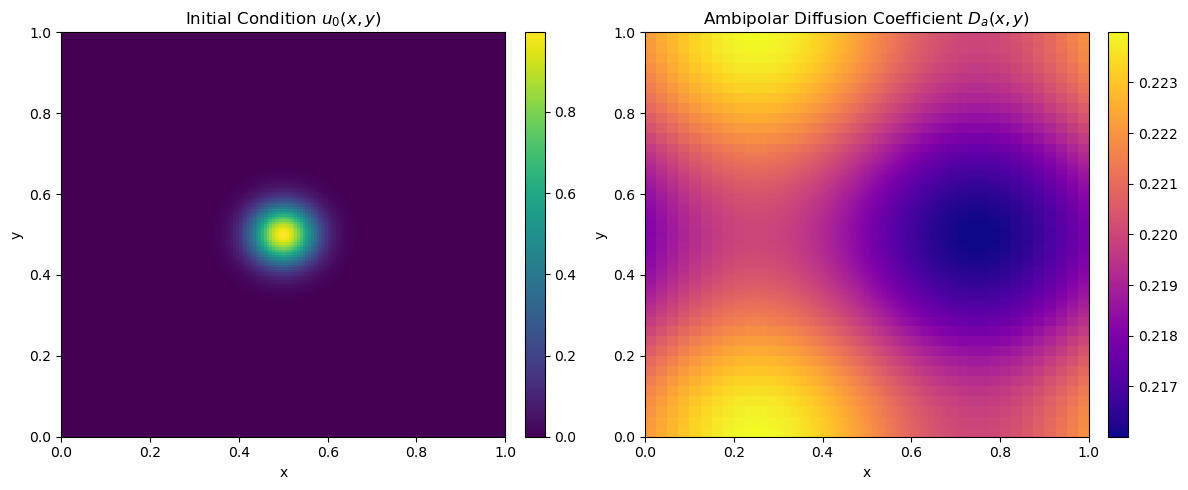

In [43]:
# ------------------------------------------------------------
# 9) PLOT INITIAL CONDITION & DIFFUSION COEFFICIENT
# ------------------------------------------------------------
# We use the Level 2 refined mesh (xc3, yc3) to see resolution details

# Re-calculate fields on the finest mesh
D_final = ambipolar_D_2d(xc3, yc3)
u0_final = initial_condition(xc3, yc3)

# Create Meshgrid for plotting
X3, Y3 = np.meshgrid(xc3, yc3, indexing="ij")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# --- Plot 1: Initial Condition (u0) ---
pcm1 = ax[0].pcolormesh(X3, Y3, u0_final, shading="nearest", cmap="viridis")
ax[0].set_title(r"Initial Condition $u_0(x,y)$")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
fig.colorbar(pcm1, ax=ax[0], fraction=0.046, pad=0.04)


# --- Plot 2: Ambipolar Diffusion Coefficient (D_a) ---
pcm2 = ax[1].pcolormesh(X3, Y3, D_final, shading="nearest", cmap="plasma")
ax[1].set_title(r"Ambipolar Diffusion Coefficient $D_a(x,y)$")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
fig.colorbar(pcm2, ax=ax[1], fraction=0.046, pad=0.04)


plt.tight_layout()
plt.show()

In [ ]:
# ------------------------------------------------------------
# 10) L2 ERROR COMPUTATION
# ------------------------------------------------------------
def compute_error_l2(xc, yc, u, xc_ref, yc_ref, u_ref):
    """
    Computes relative L2 error by interpolating u onto the reference grid.
    """
    # 1. Create interpolator for the current solution
    # bounds_error=False allow small float tolerance issues at boundaries
    interp = RegularGridInterpolator(
        (xc, yc), u, bounds_error=False, fill_value=None
    )

    # 2. Generate points for reference grid
    Xc_ref, Yc_ref = np.meshgrid(xc_ref, yc_ref, indexing="ij")
    points_ref = np.array([Xc_ref.ravel(), Yc_ref.ravel()]).T

    # 3. Interpolate
    u_interp = interp(points_ref).reshape(u_ref.shape)

    # 4. Compute Norms
    diff_norm = np.linalg.norm(u_interp - u_ref)
    ref_norm = np.linalg.norm(u_ref)

    if ref_norm < 1e-12:
        return diff_norm
    return diff_norm / ref_norm


# ------------------------------------------------------------
# 11) BENCHMARKING UNIFORM VS ADAPTIVE REFINEMENT
# ------------------------------------------------------------
def run_benchmark():
    dt = 1e-4
    T = 0.01

    # 1. Generate Reference Solution (High Res Uniform)
    print("--- Generating Reference Solution (256x256) ---")
    # Using 256x256 as Ground Truth (must be finer than test levels)
    Nx_ref, Ny_ref = 256, 256
    x_ref, y_ref, xc_ref, yc_ref = make_uniform_mesh_2d(Nx_ref, Ny_ref)
    D_ref = ambipolar_D_2d(xc_ref, yc_ref)
    u0_ref = initial_condition(xc_ref, yc_ref)

    t_start = time.time()
    u_ref, _ = crank_nicolson_2d(x_ref, y_ref, D_ref, u0_ref, dt, T)
    print(f"Reference computed in {time.time() - t_start:.2f}s")

    # 2. Settings for Benchmark
    start_Nx, start_Ny = 16, 16
    levels_to_run = 5

    # ------------------
    # UNIFORM SEQUENCE
    # ------------------
    print("\n--- Running Uniform Refinement Benchmark ---")
    uni_times = []
    uni_dofs = []
    uni_errors = []

    x, y, xc, yc = make_uniform_mesh_2d(start_Nx, start_Ny)

    for level in range(levels_to_run):
        D = ambipolar_D_2d(xc, yc)
        u0 = initial_condition(xc, yc)
        dof = len(xc) * len(yc)

        t0 = time.time()
        u_sol, _ = crank_nicolson_2d(x, y, D, u0, dt, T)
        t1 = time.time()

        elapsed = t1 - t0
        err = compute_error_l2(xc, yc, u_sol, xc_ref, yc_ref, u_ref)

        uni_times.append(elapsed)
        uni_dofs.append(dof)
        uni_errors.append(err)

        print(
            f"Level {level}: {dof:6d} DOFs | Time: {elapsed:.4f}s | Rel Error: {err:.2e}"
        )

        if level < levels_to_run - 1:
            x, y, xc, yc = refine_uniform_mesh_2d(x, y)

    # ------------------
    # ADAPTIVE SEQUENCE
    # ------------------
    print("\n--- Running Adaptive Refinement Benchmark ---")
    amr_times = []
    amr_dofs = []
    amr_errors = []

    x, y, xc, yc = make_uniform_mesh_2d(start_Nx, start_Ny)
    u_prev = None

    for level in range(levels_to_run):
        D = ambipolar_D_2d(xc, yc)
        u0 = initial_condition(xc, yc)
        dof = len(xc) * len(yc)

        t0 = time.time()
        u_curr, _ = crank_nicolson_2d(x, y, D, u0, dt, T)
        t1 = time.time()

        elapsed = t1 - t0
        err = compute_error_l2(xc, yc, u_curr, xc_ref, yc_ref, u_ref)

        amr_times.append(elapsed)
        amr_dofs.append(dof)
        amr_errors.append(err)

        print(
            f"Level {level}: {dof:6d} DOFs | Time: {elapsed:.4f}s | Rel Error: {err:.2e}"
        )

        if level < levels_to_run - 1:
            x, y, xc, yc = refine_adaptive_mesh(
                x, y, u_curr, threshold_ratio=0.15
            )
            u_prev = u_curr

    return uni_dofs, uni_times, uni_errors, amr_dofs, amr_times, amr_errors


# Run Benchmark
results = run_benchmark()
uni_dofs, uni_times, uni_errors, amr_dofs, amr_times, amr_errors = results
print("Done")

--- Generating Reference Solution (256x256) ---
Reference computed in 35.21s

--- Running Uniform Refinement Benchmark ---
Level 0:    256 DOFs | Time: 0.0496s | Rel Error: 4.70e-02
Level 1:   1024 DOFs | Time: 0.2104s | Rel Error: 1.12e-02
Level 2:   4096 DOFs | Time: 0.9260s | Rel Error: 2.72e-03
Level 3:  16384 DOFs | Time: 5.6409s | Rel Error: 7.14e-04
Level 4:  65536 DOFs | Time: 29.8653s | Rel Error: 0.00e+00

--- Running Adaptive Refinement Benchmark ---
Level 0:    256 DOFs | Time: 0.0487s | Rel Error: 4.70e-02
Level 1:    576 DOFs | Time: 0.1122s | Rel Error: 1.19e-02
Level 2:   1444 DOFs | Time: 0.2883s | Rel Error: 4.57e-03
Level 3:   4356 DOFs | Time: 0.9751s | Rel Error: 3.36e-03
Level 4:  14400 DOFs | Time: 3.9185s | Rel Error: 3.14e-03


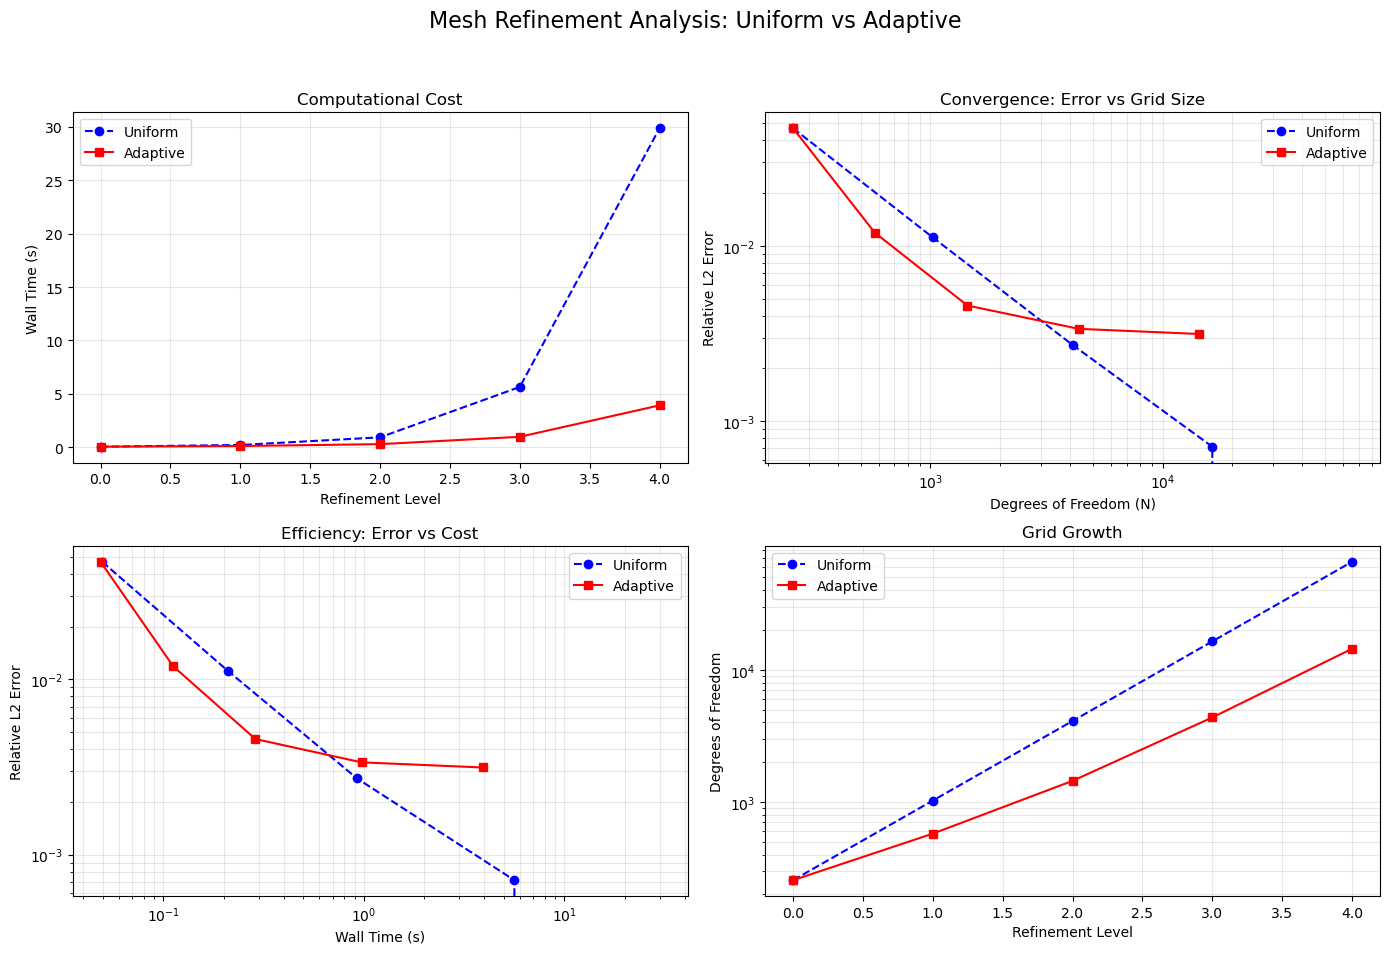

In [45]:
# ------------------------------------------------------------
# 12) PLOTTING BENCHMARK RESULTS
# ------------------------------------------------------------
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# A) Wall Time vs Refinement Level
levels = np.arange(len(uni_times))
ax[0, 0].plot(levels, uni_times, "o--", label="Uniform", color="blue")
ax[0, 0].plot(levels, amr_times, "s-", label="Adaptive", color="red")
ax[0, 0].set_xlabel("Refinement Level")
ax[0, 0].set_ylabel("Wall Time (s)")
ax[0, 0].set_title("Computational Cost")
ax[0, 0].grid(True, alpha=0.3)
ax[0, 0].legend()

# B) Error vs Degrees of Freedom (Convergence)
ax[0, 1].loglog(uni_dofs, uni_errors, "o--", label="Uniform", color="blue")
ax[0, 1].loglog(amr_dofs, amr_errors, "s-", label="Adaptive", color="red")
ax[0, 1].set_xlabel("Degrees of Freedom (N)")
ax[0, 1].set_ylabel("Relative L2 Error")
ax[0, 1].set_title("Convergence: Error vs Grid Size")
ax[0, 1].grid(True, which="both", alpha=0.3)
ax[0, 1].legend()

# C) Error vs Wall Time (Efficiency)
ax[1, 0].loglog(uni_times, uni_errors, "o--", label="Uniform", color="blue")
ax[1, 0].loglog(amr_times, amr_errors, "s-", label="Adaptive", color="red")
ax[1, 0].set_xlabel("Wall Time (s)")
ax[1, 0].set_ylabel("Relative L2 Error")
ax[1, 0].set_title("Efficiency: Error vs Cost")
ax[1, 0].grid(True, which="both", alpha=0.3)
ax[1, 0].legend()

# D) Growth of Unknowns
ax[1, 1].semilogy(levels, uni_dofs, "o--", label="Uniform", color="blue")
ax[1, 1].semilogy(levels, amr_dofs, "s-", label="Adaptive", color="red")
ax[1, 1].set_xlabel("Refinement Level")
ax[1, 1].set_ylabel("Degrees of Freedom")
ax[1, 1].set_title("Grid Growth")
ax[1, 1].grid(True, which="both", alpha=0.3)
ax[1, 1].legend()

plt.suptitle("Mesh Refinement Analysis: Uniform vs Adaptive", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()